- https://deep-learning-study.tistory.com/534
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/Classification/ResNet(2015).ipynb

In [1]:
# import package
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torchsummary import summary 
from torch import optim 
from torch.optim.lr_scheduler import StepLR 

from torchvision import datasets 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader 

from torchvision import utils 
import matplotlib.pyplot as plt 
plt.ion()   # 대화형 모드

import os, time, copy 
import numpy as np

In [2]:
# download data
data_transform = {
  'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
  ]),
  'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
  ])
}

data_dir = '../data/hymenoptera_data'
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transform['train'])
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transform['val'])

print(len(train_ds))
print(len(val_ds))
print(train_ds[0][0].numpy().shape)

244
153
(3, 224, 224)


In [3]:
print(train_ds[0][0].numpy().shape)
print(train_ds[100][0].numpy().shape)
print(train_ds[200][0].numpy().shape)

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


In [4]:
print(train_ds[37][0].numpy().shape)
print(train_ds[235][0].numpy().shape)
print(train_ds[140][0].numpy().shape)

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


In [5]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = np.array([
  np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds
])
train_stdRGB = np.array([
  np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds
])

train_meanRGB = np.mean(train_meanRGB, axis=0)
train_meanR = train_meanRGB[0]
train_meanG = train_meanRGB[1]
train_meanB = train_meanRGB[2]
train_stdRGB = np.mean(train_stdRGB, axis=0)
train_stdR = train_stdRGB[0]
train_stdG = train_stdRGB[1]
train_stdB = train_stdRGB[2]

val_meanRGB = np.array([
  np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds
])
val_stdRGB = np.array([
  np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds
])
val_meanRGB = np.mean(val_meanRGB, axis=0)
val_meanR = val_meanRGB[0]
val_meanG = val_meanRGB[1]
val_meanB = val_meanRGB[2]
val_stdRGB = np.mean(val_stdRGB, axis=0)
val_stdR = val_stdRGB[0]
val_stdG = val_stdRGB[1]
val_stdB = val_stdRGB[2]

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.51425785 0.47601447 0.3487255
0.5223656 0.4798933 0.35633498


In [6]:
# define the image transformation
train_transformation = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224)),
  transforms.Normalize(
    [train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]
  ),
  transforms.RandomHorizontalFlip()
])
val_transformation = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224)),
  transforms.Normalize(
    [val_meanR, val_meanG, val_meanB], [val_stdR, val_stdG, val_stdB]
  )
])

In [7]:
# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 37 235 140  72]


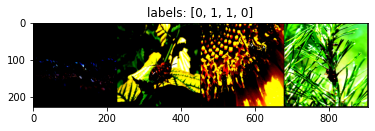

In [8]:
# display sample images
def show(img, y=None, color=True):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title(f'labels: {str(y)}')
    
np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print(f'image indices: {rnd_inds}')

x_grid = [
  train_ds[i][0] for i in rnd_inds
]
y_grid = [
  train_ds[i][1] for i in rnd_inds
]
x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [9]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정
    self.residual_function = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels * BasicBlock.expansion)
    )

    # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용
    self.shortcut = nn.Sequential()
    self.relu = nn.ReLU()

    # projection mapping using 1x1 conv
    if stride != 1 or in_channels != out_channels * BasicBlock.expansion:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion)
      )

  def forward(self, x):
    x = self.residual_function(x) + self.shortcut(x)
    x = self.relu(x)
    return x

In [10]:
class BottleNeck(nn.Module):
  expansion = 4
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_function = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
      nn.BatchNorm2d(out_channels * BottleNeck.expansion)
    )

    self.shortcut = nn.Sequential()
    self.relu = nn.ReLU()

    if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels * BottleNeck.expansion)
      )

  def forward(self, x):
    x = self.residual_function(x) + self.shortcut(x)
    x = self.relu(x)
    return x

In [11]:
class ResNet(nn.Module):
  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks -1)
    layers = []
    for _stride in strides:
      layers.append(
        block(self.in_channels, out_channels, _stride)
      )
      self.in_channels = out_channels * block.expansion
    
    return nn.Sequential(*layers)

  # define weight initialization function
  def _initialize_weights(self):
    # self.modules() -> 모델 클래스에서 정의된 layer들을 iterable로 차례로 반환
    # https://supermemi.tistory.com/121
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        # He-initialization이라고도 불림.
        # relu 나 leaky_relu를 activation function으로 사용하는 경우 많이 사용함.
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
  
  def __init__(self, block, num_block, num_classes=10, init_weights=True):
    super().__init__()

    self.in_channels = 64
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
    self.conv3_x = self._make_layer(block, 128, num_block[1], 1)
    self.conv4_x = self._make_layer(block, 256, num_block[2], 1)
    self.conv5_x = self._make_layer(block, 512, num_block[3], 1)
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    if init_weights:
      self._initialize_weights()
    
  def forward(self, x):
    _x = self.conv1(x)
    _x = self.conv2_x(_x)
    _x = self.conv3_x(_x)
    _x = self.conv4_x(_x)
    _x = self.conv5_x(_x)
    _x = self.avg_pool(_x)
    _x = _x.view(_x.size(0), -1)
    return self.fc(_x)

In [12]:
def resnet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
  return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
  return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
  return ResNet(BottleNeck, [3, 8, 36, 3])

In [15]:
device = torch.device(
  'cuda' if torch.cuda.is_available() else 'cpu'
)
model = resnet18().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [16]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,